# Import Dependencies

In [3]:
# Dependencies
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Read Data File

In [4]:
# Data File
data = "../Resources/FINAL_CLEAN_FILE.csv"

# read to dataframe
data_df = pd.read_csv(data)
data_df.head()

,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,SEVERITY_LEVEL,DIED,L_THREAT,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,916600,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,33.0,26-35,0.0,...,False,False,True,False,False,False,False,False,False,False
1,916601,Anxiety,Anxiety,MILD,0.0,0.0,0.0,73.0,66-75,1.0,...,True,False,False,False,False,False,True,False,False,False
2,916602,Chest discomfort,Chest Discomfort,MILD,0.0,0.0,0.0,23.0,18-25,0.0,...,False,True,False,False,False,False,False,False,False,False
3,916604,Injection site erythema,Injection Site Irritation/Discomfort,MILD,0.0,0.0,0.0,47.0,46-55,0.0,...,False,False,False,False,True,False,False,False,False,False
4,916606,Pharyngeal swelling,Throat Irritation/Discomfort,MILD,0.0,0.0,0.0,44.0,36-45,0.0,...,False,False,False,True,False,False,False,False,False,False


In [5]:
severity = data_df['SEVERITY_LEVEL'].unique()
severity

array(['MILD', 'MODERATE', 'SEVERE'], dtype=object)

In [6]:
data_df.groupby(data_df['SEVERITY_LEVEL']).count()

,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,DIED,L_THREAT,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,CUR_ILL,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
SEVERITY_LEVEL,,,,,,,,,,,,,,,,,,,,,
MILD,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836,...,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836
MODERATE,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984,...,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984
SEVERE,662,662,662,662,662,662,662,662,662,662,...,662,662,662,662,662,662,662,662,662,662


In [8]:
data_df.columns

Index(['VAERS_ID', 'SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'DIED',
       'L_THREAT', 'HOSPITAL', 'AGE_YRS', 'AGE_GROUP', 'OTHER_MEDS', 'CUR_ILL',
       'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA',
       'PFIZER', 'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', 'VAX_SITE_LA',
       'VAX_SITE_RA', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75',
       '76-85', '86-95', '96 +'],
      dtype='object')

In [9]:
view_correlation = data_df[['VAERS_ID','SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'HOSPITAL', 'AGE_YRS', 'AGE_GROUP', 'OTHER_MEDS',
                        'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER', 
                        'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', 'VAX_SITE_LA', 'VAX_SITE_RA']]

Non-numeric columns: Index(['SYMPTOM', 'ASSIGNED_GROUP', 'SEVERITY_LEVEL', 'AGE_GROUP', 'F', 'M',
       'JANSSEN', 'MODERNA', 'PFIZER', 'VAX_DOSE_SERIES_1',
       'VAX_DOSE_SERIES_2', 'VAX_SITE_LA', 'VAX_SITE_RA'],
      dtype='object')


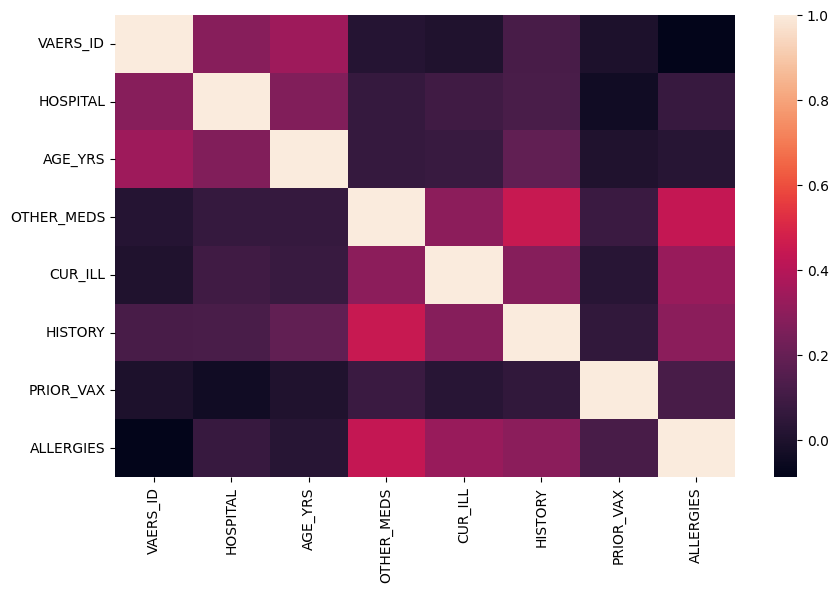

In [14]:
# Assuming 'view_correlation' is your DataFrame
# Identify non-numeric columns
non_numeric_columns = view_correlation.select_dtypes(exclude=['float', 'int']).columns

# Display non-numeric columns
print("Non-numeric columns:", non_numeric_columns)

# If these columns are not necessary for correlation calculation, you can drop them
view_correlation_numeric = view_correlation.drop(columns=non_numeric_columns)

# Now, plot the heatmap with the numeric data
plt.figure(figsize=(10, 6))
sns.heatmap(view_correlation_numeric.corr())
plt.show()


# Prep Data for Model

In [15]:
# Create Features by dropping columns we do not need (or already have in feature format)
X = data_df.drop(['VAERS_ID', 'SYMPTOM','ASSIGNED_GROUP','SEVERITY_LEVEL','HOSPITAL', 'DIED', 'L_THREAT', 'CUR_ILL', 'VAX_SITE_LA', 'VAX_SITE_RA', 'AGE_YRS', 'AGE_GROUP'], axis=1)
X

,OTHER_MEDS,HISTORY,PRIOR_VAX,ALLERGIES,F,M,JANSSEN,MODERNA,PFIZER,VAX_DOSE_SERIES_1,VAX_DOSE_SERIES_2,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,0.0,0.0,0.0,1.0,True,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False
1,1.0,1.0,0.0,1.0,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False
2,0.0,0.0,0.0,1.0,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False
3,0.0,0.0,0.0,0.0,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False
4,0.0,0.0,0.0,1.0,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26477,1.0,0.0,0.0,0.0,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False
26478,0.0,1.0,0.0,0.0,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False
26479,0.0,1.0,0.0,0.0,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False
26480,0.0,1.0,0.0,0.0,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False


In [16]:
# Create Target (Severity Level column) and convert to numbers
y = LabelEncoder().fit_transform(data_df['SEVERITY_LEVEL'])
y

array([0, 0, 0, ..., 1, 0, 0])

In [17]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Evaluate Model Function

In [18]:
def evaluate(pipeline, X_train, X_test, y_train, y_test):
    '''
    Evaluate a pipeline on training and test datasets
    '''    
    pipeline.fit(X_train, y_train)
    y_train_hat = pipeline.predict(X_train)
    y_test_hat = pipeline.predict(X_test)
    train_f1 = f1_score(y_train_hat, y_train,average='micro')
    train_acc = accuracy_score(y_train_hat, y_train)
    test_f1 = f1_score(y_test_hat, y_test, average='micro')
    test_acc = accuracy_score(y_test_hat, y_test)

    print(f"========== Predictor: {type(pipeline).__name__} ==========")
    print(f"Training result: f1: {train_f1:.3f}, acc: {train_acc:.3f}")
    print(f"Test result: f1: {test_f1:.3f}, acc: {test_acc:.3f}")
    print()

# Start with Logistic Regression

In [19]:
# try LogisticRegression to establish a baseline performance
model = LogisticRegression(max_iter=1000)
evaluate(model, X_train, X_test, y_train, y_test)

========== Predictor: LogisticRegression ==========
Training result: f1: 0.900, acc: 0.900
Test result: f1: 0.902, acc: 0.902



In [20]:
# try other predictors
evaluate(XGBClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(RandomForestClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

========== Predictor: XGBClassifier ==========
Training result: f1: 0.901, acc: 0.901
Test result: f1: 0.900, acc: 0.900

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 19861, number of used features: 20
[LightGBM] [Info] Start training from score -0.105803
[LightGBM] [Info] Start training from score -2.589311
[LightGBM] [Info] Start training from score -3.675923
========== Predictor: LGBMClassifier ==========
Training result: f1: 0.900, acc: 0.900
Test result: f1: 0.901, acc: 0.901

========== Predictor: RandomForestClassifier ==========
Training result: f1: 0.901, acc: 0.901
Test result: f1: 0.900, acc: 0.900

========== Predictor: GradientB

# Save the Model

In [21]:
# save model
with open(f'../final_regression_model.sav', 'wb') as f:
    pickle.dump(model, f)
    

# User Input

In [22]:
# Define list of features and create empty user input list
features_np = ['OTHER_MEDS', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER',
       'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95',
       '96 +']
user_input = np.zeros(len(features_np))

In [23]:
# Raw User Input from user fields
age_group = '56-65'
sex = 'F'
other_meds = 1
history = 1
prior_vax = 1
allergies = 1
vax_name = 'PFIZER'
vax_dose = '2'

# Convert user input to list for model

age_idx = features_np.index(f'{age_group}')
sex_idx = features_np.index(f'{sex}')
vax_idx = features_np.index(f'{vax_name}')
dose_idx = features_np.index(f'VAX_DOSE_SERIES_{vax_dose}')

user_input[0] = other_meds
user_input[1] = history
user_input[2] = prior_vax
user_input[3] = allergies
user_input[sex_idx] = 1
user_input[vax_idx] = 1
user_input[dose_idx] = 1
user_input[age_idx] = 1


print(user_input)

[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [24]:
# Real Prediction
user_test = user_input
predicted_symptoms = model.predict([user_test])
print(predicted_symptoms)

[0]


c:\Users\91830\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
